<a href="https://colab.research.google.com/github/chandrusuresh/Hands-On-ML/blob/master/Ch7-EnsembleLearning/EnsembleLearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Ensemble Learning
Ensemble methods work best when the predictors are independent from one another as possible. One way to get diverse classifiers is to train them using different algorithms. This increases the chance they will make very different types of erros, improving the ensemble's accuracy by reducing bias, variace or both.

The ensenmble classifier works by aggregating the predictions of each classifier and predict the class that gets the most votes (statistical mode). This majority vote classifier is called hard-voting classifier.

If all classifiers are able to estimate class probabilities, then Scikit-Learn can predict the class with the highest class probability, averaged over all the individual classifiers. This is called soft-voting. Soft-voting often achieves higher performance than hard voting because it gives  more weight to highly confident votes.

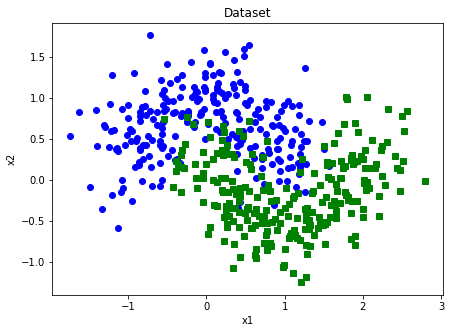

In [2]:
from sklearn.datasets import make_moons
X,y = make_moons(n_samples=500,noise=0.3,random_state=42)
idx = []
for yi in np.unique(y):
  idx += [np.where(y == yi)[0]]

fig,ax = plt.subplots(1,1,figsize=(7,5))
ax.set_title('Dataset')
ax.set_xlabel('x1')
ax.set_ylabel('x2')
marker = ['bo','gs']
for i in range(len(idx)):
  ax.plot(X[idx[i],0],X[idx[i],1],marker[i])

### Split Training and Test

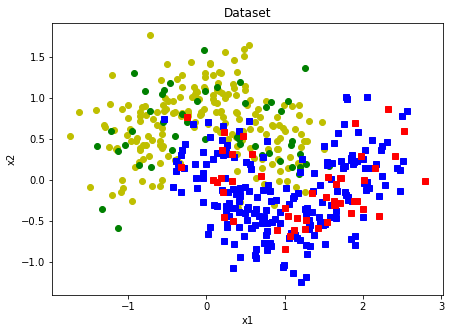

In [3]:
from sklearn.model_selection import StratifiedShuffleSplit

sssplit = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_idx,test_idx in sssplit.split(X,y):
  X_train,y_train = X[train_idx,:],y[train_idx]
  X_test,y_test = X[test_idx,:],y[test_idx]

idx_train = []
for yi in np.unique(y_train):
  idx_train += [np.where(y_train == yi)[0]]

idx_test = []
for yi in np.unique(y_test):
  idx_test += [np.where(y_test == yi)[0]]

fig,ax = plt.subplots(1,1,figsize=(7,5))
ax.set_title('Dataset')
ax.set_xlabel('x1')
ax.set_ylabel('x2')

marker = ['yo','go','bs','rs']
for i in range(len(idx)):
  ax.plot(X_train[idx_train[i],0],X_train[idx_train[i],1],marker[i*2])
  ax.plot(X_test[idx_test[i],0],X_test[idx_test[i],1],marker[i*2+1])

## Voting Classifier

In [4]:
from sklearn.ensemble import VotingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

log_clf = LogisticRegression()
rf_clf = RandomForestClassifier()#max_depth=2)
svm_clf = SVC()

voting_clf = VotingClassifier(estimators=[('lr',log_clf),('rf',rf_clf),('svc',svm_clf)],voting='hard');
voting_clf.fit(X_train,y_train);

In [5]:
from sklearn.metrics import accuracy_score
import pandas as pd

lr_train_pred = voting_clf.named_estimators_.lr.predict(X_train)
rf_train_pred = voting_clf.named_estimators_.rf.predict(X_train)
svc_train_pred = voting_clf.named_estimators_.svc.predict(X_train)
vc_train_pred = voting_clf.predict(X_train)

lr_test_pred = voting_clf.named_estimators_.lr.predict(X_test)
rf_test_pred = voting_clf.named_estimators_.rf.predict(X_test)
svc_test_pred = voting_clf.named_estimators_.svc.predict(X_test)
vc_test_pred = voting_clf.predict(X_test)

scores = dict()
index = ['LogisticRegression','RandomForest','SVC','Ensemble']
scores['Training Accuracy'] = [accuracy_score(y_train,lr_train_pred),accuracy_score(y_train,rf_train_pred),accuracy_score(y_train,svc_train_pred),accuracy_score(y_train,vc_train_pred)]
scores['Test Accuracy'] = [accuracy_score(y_test,lr_test_pred),accuracy_score(y_test,rf_test_pred),accuracy_score(y_test,svc_test_pred),accuracy_score(y_test,vc_test_pred)]

df = pd.DataFrame.from_dict(data=scores)
df.index = index
df

,Training Accuracy,Test Accuracy
LogisticRegression,0.8475,0.81
RandomForest,1.0000,0.88
SVC,0.9275,0.93
Ensemble,0.9400,0.91


## Bagging & Pasting
One way to make the set of classifiers that make up the ensemble independent is by using different learning algorithms for each as above. Another approach is to use the same training algorothm for each predictor and train them on different random subsets of the training set.

**Bagging** (Bootstrap Aggregating) is the approach when the sampling is performed with replacement.

**Pasting** is the approach when the sampling is performed without replacement.

Both bagging and pasting allow training instances to be sampeld several times across multiple predictors, but only bagging allows training instances to be sampled several times for the same predictor.


In [6]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

tree_clf = DecisionTreeClassifier();
bag_clf = BaggingClassifier(DecisionTreeClassifier(),n_estimators=500,max_samples=100,bootstrap=True,n_jobs=-1,random_state=42);

tree_clf.fit(X,y);
bag_clf.fit(X,y);

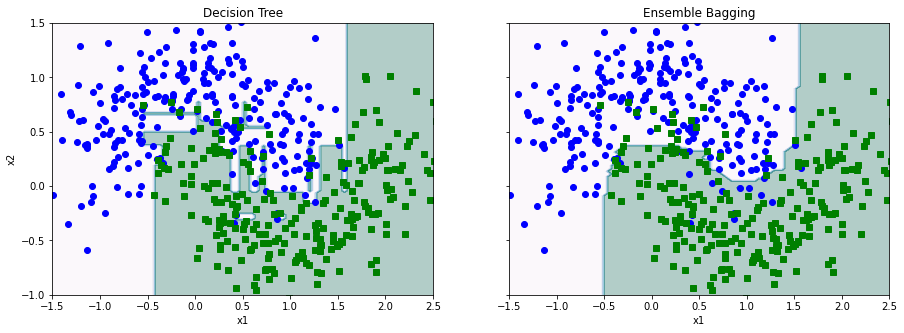

In [7]:
x0_new = np.linspace(-1.5,2.5,100)
x1_new = np.linspace(-1.0,1.5,100)
X0,X1 = np.meshgrid(x0_new,x1_new)
X_new = np.c_[np.ravel(X0),np.ravel(X1)]
tree_pred = tree_clf.predict(X_new).reshape(X0.shape)
bag_pred = bag_clf.predict(X_new).reshape(X0.shape)

fig,ax = plt.subplots(1,2,figsize=(15,5),sharey=True)
titles = ['Decision Tree', 'Ensemble Bagging']
marker = ['bo','gs']
ax[0].set_ylabel('x2')
for j in range(2):
  ax[j].set_title(titles[j])
  ax[j].set_xlabel('x1')
  for i in range(len(idx)):
    ax[j].plot(X[idx[i],0],X[idx[i],1],marker[i])

ax[0].contourf(X0,X1,tree_pred,cmap='PuBuGn',alpha=0.3)
ax[1].contourf(X0,X1,bag_pred,cmap='PuBuGn',alpha=0.3)
ax[0].set_xlim([-1.5,2.5]);
ax[1].set_xlim([-1.5,2.5]);
ax[0].set_ylim([-1.0,1.5]);
  

### Out-of-Bag Evaluation
Note that with bagging, some instances may be sampled several times for any given predictor, while others may not be sampled at all. As the number of instances grows, only ~63% ($1-\exp(-1))$ of training instances are sampled on average for each predictor. The remaining 37% that are not sampled are called out-of-bag (oob) instances. So instead of a validation set, the performance can be evaluated with the prediction accuracy with the oob instances by setting the `oob_score` attribute to `True`.

In [8]:
bag_clf_oob = BaggingClassifier(DecisionTreeClassifier(),n_estimators=500,max_samples=100,bootstrap=True,n_jobs=-1,random_state=42,oob_score=True);
bag_clf_oob.fit(X_train,y_train)
print('OOB score:',bag_clf_oob.oob_score_)
print('Training score:',accuracy_score(y_train,bag_clf_oob.predict(X_train)))
print('Test score:',accuracy_score(y_test,bag_clf_oob.predict(X_test)))


OOB score: 0.91
Training score: 0.9375
Test score: 0.92


Ensemble Learning vs Decision Trees (with Rotated Data)

['setosa' 'versicolor' 'virginica']


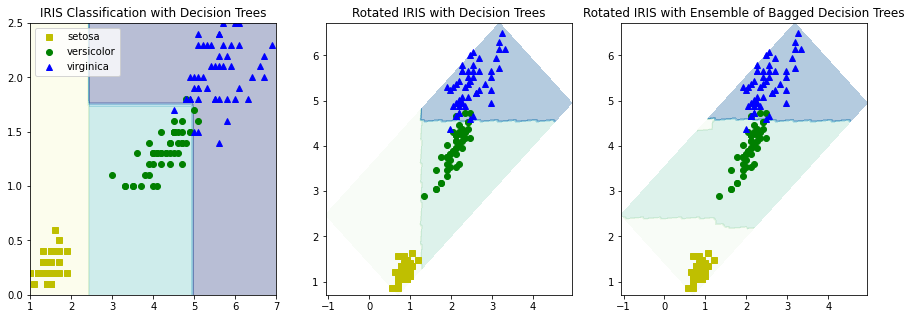

In [51]:
from sklearn.datasets import load_iris
iris = load_iris()
print(iris.target_names)
idx = []
for i in range(len(iris.target_names)):
  idx += [np.where(iris['target'] == i)[0]]

marker = ['ys','go','b^']
fig,ax = plt.subplots(1,3,figsize=(15,5))

y_setosa = iris['target']#(iris['target'] == 2).astype(np.int)
tree_clf_iris = DecisionTreeClassifier(max_depth=3,random_state=42)
tree_clf_iris.fit(iris['data'][:,2:],y_setosa)

pl = np.linspace(1,7,100)
pw = np.linspace(0,2.5)
X0,X1 = np.meshgrid(pl,pw)
X_pred_setosa = np.c_[np.ravel(X0),np.ravel(X1)]
y_pred_setosa = tree_clf_iris.predict(X_pred_setosa).reshape(X0.shape)

idx_setosa = []
for i in range(3):
  idx_setosa += [np.where(y_setosa == i)[0]]

for i in range(len(idx_setosa)):
  ax[0].plot(iris['data'][idx_setosa[i],2],iris['data'][idx_setosa[i],3],marker[i])
ax[0].contourf(X0,X1,y_pred_setosa,cmap='YlGnBu',alpha=0.3)
ax[0].legend(iris['target_names']);
ax[0].set_title('IRIS Classification with Decision Trees');


X_rot0 = iris['data'][:,2]*np.cos(np.pi/4) - iris['data'][:,3]*np.sin(np.pi/4)
X_rot1 = iris['data'][:,2]*np.sin(np.pi/4) + iris['data'][:,3]*np.cos(np.pi/4)
X_rot = np.c_[X_rot0,X_rot1]
for i in range(len(idx_setosa)):
  ax[1].plot(X_rot[idx_setosa[i],0],X_rot[idx_setosa[i],1],marker[i])
  ax[2].plot(X_rot[idx_setosa[i],0],X_rot[idx_setosa[i],1],marker[i])
ax[1].set_title('Rotated IRIS with Decision Trees')
ax[2].set_title('Rotated IRIS with Ensemble of Bagged Decision Trees')

tree_clf_iris_rot = DecisionTreeClassifier(max_depth=3,random_state=42)
tree_clf_iris_rot.fit(X_rot,y_setosa)

X0_rot = X0*np.cos(np.pi/4) - X1*np.sin(np.pi/4)
X1_rot = X0*np.sin(np.pi/4) + X1*np.cos(np.pi/4)
X_pred_setosa_rot = np.c_[np.ravel(X0_rot),np.ravel(X1_rot)]

y_pred_setosa_rot = tree_clf_iris_rot.predict(X_pred_setosa_rot).reshape(X0.shape)
ax[1].contourf(X0_rot,X1_rot,y_pred_setosa_rot,cmap='GnBu',alpha=0.3)


bag_clf_iris_rot = BaggingClassifier(DecisionTreeClassifier(max_depth=3),n_estimators=500,max_samples=100,bootstrap=True,n_jobs=-1,random_state=42);
bag_clf_iris_rot.fit(X_rot,y_setosa)
y_pred_setosa_bag_rot = bag_clf_iris_rot.predict(X_pred_setosa_rot).reshape(X0.shape)
ax[2].contourf(X0_rot,X1_rot,y_pred_setosa_bag_rot,cmap='GnBu',alpha=0.3);